# Automatic Speech Recognition using CTC

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tens
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

## Load the LJSpeech Dataset

Let's download the [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/).
The dataset contains 13,100 audio files as `wav` files in the `/wavs/` folder.
The label (transcript) for each audio file is a string
given in the `metadata.csv` file. The fields are:

- **ID**: this is the name of the corresponding .wav file
- **Transcription**: words spoken by the reader (UTF-8)
- **Normalized transcription**: transcription with numbers,
ordinals, and monetary units expanded into full words (UTF-8).

For this demo we will use on the "Normalized transcription" field.

Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

In [2]:
#data_download_url1 = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
DSurl = "LJSpeech-1.1/LJSpeech-1.1/" #keras.utils.get_file("LJSpeech-1.1", data_download_url1, untar=True)#
Wurl = DSurl + "/wavs/"
metaUrl = DSurl + "/metadata.csv"


# Read metadata file and parse it
metaDf = pd.read_csv(metaUrl, sep="|", header=None)
metaDf.columns = ["file_name", "transcription", "normalized_transcription"]
metaDf = metaDf[["file_name", "normalized_transcription"]]
metaDf = metaDf.sample(frac=1).reset_index(drop=True)
metaDf.dropna(how="any",inplace = True)
metaDf.head()

,file_name,normalized_transcription
0,LJ008-0087,The change from Tyburn to the Old Bailey had w...
1,LJ008-0206,and caused a number of stout additional barrie...
2,LJ028-0414,All the ground on which Babylon was spread is ...
3,LJ050-0125,Once experience has been gained in implementin...
4,LJ018-0288,After this the other conspirators traveled to ...


We now split the data into training and validation set.

In [3]:
split = int(len(metaDf) * 0.90)
ds_train = metaDf[:split]
ds_val = metaDf[split:]

print(f"Size of the training set: {len(ds_train)}")
print(f"Size of the training set: {len(ds_val)}")


Size of the training set: 11574
Size of the training set: 1286


## Preprocessing

We first prepare the vocabulary to be used.

In [4]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
charTnum = tens.keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
numTchar = tens.keras.layers.StringLookup(vocabulary=charTnum.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary is: {charTnum.get_vocabulary()} "f"(size ={charTnum.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [5]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, labels):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tens.io.read_file(Wurl + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tens.audio.decode_wav(file)
    audio = tens.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tens.cast(audio, tens.float32)
    # 4. Get the spectrogram
    spectrogram = tens.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tens.abs
    spectrogram = tens.abs(spectrogram)
    spectrogram = tens.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tens.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tens.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    labels = tens.strings.lower(labels)
    # 8. Split the label
    labels = tens.strings.unicode_split(labels, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    labels = charTnum(labels)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, labels


## Creating `Dataset` objects

In [6]:
batch_size = 2
 # Define the trainig dataset
train_ds = tens.data.Dataset.from_tensor_slices((list(ds_train["file_name"]), list(ds_train["normalized_transcription"])))
train_ds = (train_ds.map(encode_single_sample, num_parallel_calls=tens.data.AUTOTUNE).padded_batch(batch_size)
        .prefetch(buffer_size=tens.data.AUTOTUNE))
# Define the validation dataset
validation_ds = tens.data.Dataset.from_tensor_slices((list(ds_val["file_name"]), list(ds_val["normalized_transcription"])))
validation_ds = (validation_ds.map(encode_single_sample, num_parallel_calls=tens.data.AUTOTUNE).padded_batch(batch_size)
        .prefetch(buffer_size=tens.data.AUTOTUNE))

## Visualize the data

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

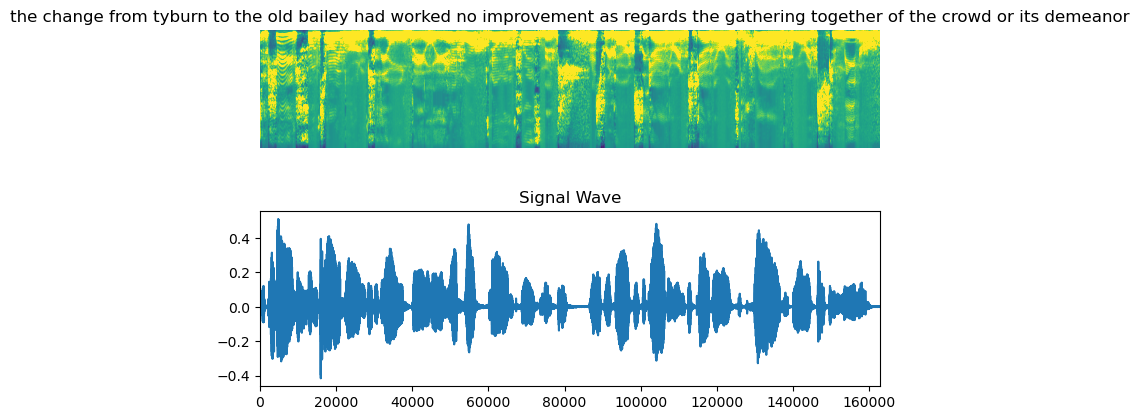

In [7]:
fig = plt.figure(figsize=(8, 5))
for batch in train_ds.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tens.strings.reduce_join(numTchar(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tens.io.read_file(Wurl + list(ds_train["file_name"])[0] + ".wav")
    audio, _ = tens.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
    plt.show()

## Model

We first define the CTC Loss function.

In [8]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tens.cast(tens.shape(y_true)[0], dtype="int64")
    input_length = tens.cast(tens.shape(y_pred)[1], dtype="int64")
    label_length = tens.cast(tens.shape(y_true)[1], dtype="int64")

    input_length = input_length * tens.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tens.ones(shape=(batch_len, 1), dtype="int64")

    loss = tens.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [9]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to SPT."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = tens.keras.Model(input_spectrogram, output, name="SPTMODEL")
    # Optimizer
    opt = tens.keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

with tens.device('/gpu:0'):
    # Get the model
    model = build_model(
        input_dim=fft_length // 2 + 1,
        output_dim=charTnum.vocabulary_size(),
        rnn_units=512,
    )
    model.summary(line_length=110)

Model: "SPTMODEL"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                        1

## Training and Evaluating

In [10]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tens.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tens.strings.reduce_join(numTchar(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(tens.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tens.strings.reduce_join(numTchar(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


Let's start the training process.

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''  

if tens.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
    # Define the number of epochs.
epochs = 70
    # Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_ds)
    # Train the model
history = model.fit(train_ds,validation_data=validation_ds,epochs=epochs,callbacks=[validation_callback])
model.save('final_model.hdf5')

GPU found
Epoch 1/70
  55/5787 [..............................] - ETA: 1:59:09 - loss: 388.5696

KeyboardInterrupt: 

## Inference

In [12]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_ds:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tens.strings.reduce_join(numTchar(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 141ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1544
----------------------------------------------------------------------------------------------------
Target    : that gentleman had come to the conclusion that the ordinary and hackneyed methods of treatment were practically inefficacious
Prediction: that entlemen had come to the conclusion that the ordinary inharckneed methods of treatment were practically in efficaes
----------------------------------------------------------------------------------------------------
Target    : it is supported by strong posts fixed into grooves made in the street
Prediction: it is supported by strong posts fixed into groues made in the street
----------------------------------------------------------------------------------------------------
Target    : but while repudiating the charges made against him of systematic extravag

## Conclusion

In practice, you should train for around 50 epochs or more. Each epoch
takes approximately 5-6mn using a `GeForce RTX 2080 Ti` GPU.
The model we trained at 50 epochs has a `Word Error Rate (WER) ≈ 16% to 17%`.

Some of the transcriptions around epoch 50:

**Audio file: LJ017-0009.wav**
```
- Target    : sir thomas overbury was undoubtedly poisoned by lord rochester in the reign
of james the first
- Prediction: cer thomas overbery was undoubtedly poisoned by lordrochester in the reign
of james the first
```

**Audio file: LJ003-0340.wav**
```
- Target    : the committee does not seem to have yet understood that newgate could be
only and properly replaced
- Prediction: the committee does not seem to have yet understood that newgate could be
only and proberly replace
```

**Audio file: LJ011-0136.wav**
```
- Target    : still no sentence of death was carried out for the offense and in eighteen
thirtytwo
- Prediction: still no sentence of death was carried out for the offense and in eighteen
thirtytwo
```

In [13]:
for batch in validation_ds:
    X, y = batch
    print(type(X))
    print(X)
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[-0.38527107 -0.19578381 -0.20457116 ... -1.4014177  -1.418869
   -1.5391663 ]
  [-0.96257806 -0.98336244 -0.64722127 ... -1.4082975  -1.4124501
   -1.4288849 ]
  [-0.6978157  -0.47687733 -0.25369972 ... -1.4181683  -1.4482622
   -1.4491378 ]
  ...
  [ 1.5832922   2.578156    3.87512    ... -1.0148939  -0.93032223
   -0.8959002 ]
  [ 3.9043863   3.4121332   2.479702   ... -0.92916614 -0.8173311
   -0.7754828 ]
  [ 3.3598313   3.5429354   3.8001816  ... -0.8970175  -0.9297037
   -1.1020083 ]]

 [[-0.17678943  0.02218298 -0.17775628 ... -1.058172   -1.0535634
   -1.0721534 ]
  [-0.08801672  0.6015431   2.273183   ... -0.6019123  -0.5993089
   -0.6129068 ]
  [-0.22789045  0.6005948   1.7144339  ... -0.6552706  -0.64935833
   -0.64609414]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.  